In [1]:
from dotenv import *
import os, subprocess
load_dotenv(find_dotenv())

project_root = '..'

In [2]:
query_path = os.path.join(project_root, os.environ['QUERY_PATH'])

# Play the query

In [3]:
import IPython
IPython.display.Audio(query_path)

# What song was actually queried?

In [4]:
target_query_path = '00013.mid';
total_songs = len(os.listdir(os.path.join(project_root, os.environ['MIDI_DIR'])))

# Measure performance

In [5]:
%%time
from utils import get_prediction_df
res_df = get_prediction_df(query_path)

CPU times: user 464 ms, sys: 276 ms, total: 740 ms
Wall time: 2.6 s


In [28]:
import numpy as np
def get_rank(res_df, path):
    if len(res_df[res_df.midi_paths.str.contains(path)]) == 0:
        return -1
    return res_df.get_value(res_df[res_df.midi_paths.str.contains(path)].index[0], 'rank')

def get_error(res_df, path):
    if len(res_df[res_df.midi_paths.str.contains(path)]) == 0:
            return np.inf
        return res_df.get_value(res_df[res_df.midi_paths.str.contains(path)].index[0], 'error')

In [7]:
rank = get_rank(res_df, target_query_path)
print 'Ranked song %d out of %d' % (rank, total_songs)

Ranked song 1 out of 2048


# Measure performance with increasing noise

In [8]:
import librosa
y, sr = librosa.load(query_path, sr=8000)

In [9]:
from scipy.stats import signaltonoise
import numpy as np

def snr(y):
    return (10 * np.log10(np.abs(signaltonoise(y))))

init_snr = snr(y)
print 'SNR = %0.02f dB' % init_snr

SNR = -10.92 dB


In [18]:
IPython.display.Audio(tmp_query_path)

In [25]:
y_noise.astype('float16')

array([ -1.46362305e-01,   3.35205078e-01,  -6.98242188e-01, ...,
         1.20312500e+00,   7.87734985e-04,  -2.00585938e+00], dtype=float16)

In [63]:
import os, scipy
tmp_query_path = '.tmp_query.wav'
y_noise = y
snrs = [init_snr]
ranks = [rank]
dfs = [res_df]
errors = []
iter_n = 0

while ranks[-1] != -1:
    iter_n += 1
    print iter_n
    y_noise = (y_noise + 0.2 * np.random.normal(0, 1, len(y))).astype('float16')
    
    scipy.io.wavfile.write(tmp_query_path, sr, y_noise)
    noise_df = get_prediction_df(tmp_query_path)
    noise_rank = get_rank(noise_df, target_query_path)
    
    dfs.append(noise_df)
    ranks.append(noise_rank)
    snrs.append(snr(y_noise))
       
os.remove(tmp_query_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [64]:
IPython.display.Audio(y_noise, rate=sr)

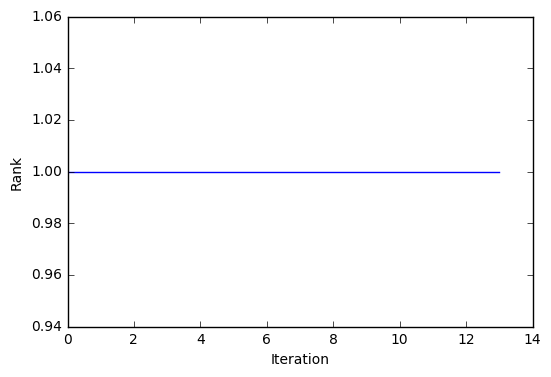

In [65]:
import matplotlib.pyplot as plt
y_ranks = ranks[:-1]
plt.plot(range(len(y_ranks)), y_ranks)
plt.ylabel('Rank')
plt.xlabel('Iteration')